<a href="https://colab.research.google.com/github/shayan-mk/Semi-supervisied_CNN_MNIST/blob/master/CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 0: Intro, team members, contributions, ...

# Code outline:

- Apply data augmentation techniques to expand the training dataset with rotation, scaling, shifting, etc. transformations.
- Train the initial fully supervised neural network on the labeled MNIST data.
- Extract deep features from the last layer before the linear classifier for both labeled and unlabeled data points.
- Perform K-means clustering on the deep features to assign cluster labels to the unlabeled data points.
- Use K-Nearest Neighbors (KNN) on the deep features to further refine the labels assigned by K-means clustering based on the labels of their nearest neighbors in the feature space.
- Combine the cross-entropy loss on labeled points with the K-means clustering loss to create a new hybrid loss function.
- Add an augmentation loss term that encourages consistent labeling of augmented training examples.
- Combine the labeled, K-means labeled, and KNN-refined labeled data points into a single dataset.
- Fine-tune the neural network using this dataset with the combined loss function (including the augmentation loss term).

Finally, Evaluate the model performance with varying amounts of labeled data (M) to demonstrate how the performance changes as M gets progressively smaller. We will do this by repeating the above steps for different proportions of labeled data.

# Section 1: Import necessary libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import math
import numpy as np
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
USE_GPU = True
EPOCH = 2
BATCH = 60

# Section 2: Define the CNN architecture

In [ ]:
class Net(nn.Module):
    # create convolutional and batch layers 1 through 8 in constructor
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, padding=1)
        self.conv1_bn = nn.BatchNorm2d(64)
        
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_bn = nn.BatchNorm2d(128)
        
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_bn = nn.BatchNorm2d(256)
        
        self.conv4 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv4_bn = nn.BatchNorm2d(256)
        
        self.conv5 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv5_bn = nn.BatchNorm2d(512)
        
        self.conv6 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv6_bn = nn.BatchNorm2d(512)
        
        self.conv7 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv7_bn = nn.BatchNorm2d(512)
        
        self.conv8 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv8_bn = nn.BatchNorm2d(512)
        # create fully connected layers and dropout
        self.fc1 = nn.Linear(512, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 10)
        
        self.dropout = nn.Dropout(0.5)

    # define forward pass through network, conversely, could use nn.sequential
    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1_bn(self.conv1(x))), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2_bn(self.conv2(x))), (2, 2))
        x = F.relu(self.conv3_bn(self.conv3(x)))
        x = F.max_pool2d(F.relu(self.conv4_bn(self.conv4(x))), (2, 2))
        x = F.relu(self.conv5_bn(self.conv5(x)))
        x = F.max_pool2d(F.relu(self.conv6_bn(self.conv6(x))), (2, 2))
        x = F.relu(self.conv7_bn(self.conv7(x)))
        x = F.max_pool2d(F.relu(self.conv8_bn(self.conv8(x))), (2, 2))
        
        x = torch.flatten(x, 1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

    # extract deep features from the last layer before the linear classifier
    def extract_deep_features(self):
        return self.fc1.weight.data


# Section 3: Load, augment, preprocess, and split the dataset
- Augment data with techniques such as random rotations, translations, and flips.
- Preprocess and split the dataset into labeled, unlabeled, and test sets.

In [ ]:
transform = transforms.Compose([
    transforms.Resize(32), 
    transforms.ToTensor()
])

data_augmentation = transforms.Compose([
    transforms.Resize(32),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor()
])

gaussian_blur_augmentation = transforms.Compose([
    transforms.Resize(32),
    transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
    transforms.ToTensor()
])

gaussian_noise_augmentation = transforms.Compose([
    transforms.Resize(32),
    transforms.Lambda(lambda x : x + math.sqrt(0.1)*torch.randn_like(x)),
    transforms.ToTensor()
])

#TODO : augment the dataset with the techniques mentioned above

In [ ]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True,
                                transform=transform)
mnist_test = datasets.MNIST(root='./data', train=False, download=True,
                               transform=transform)

# TODO: Split the train set into labeled and unlabeled sets properly based on M
labeled_loader = torch.utils.data.DataLoader(mnist_train, BATCH, shuffle=True)
unlabeled_loader = torch.utils.data.DataLoader(mnist_train, BATCH, shuffle=True)

test_loader = torch.utils.data.DataLoader(mnist_test, 1, shuffle=True)

# Section 5: Initialize the model, loss function, and optimizer

- Net as model
- CrossEntropyLoss as loss function
- SGD as optimizer (weight update)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() and USE_GPU else "cpu")
net = Net()
loss = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01)
net.to(device)

Net(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6_bn): BatchNorm2d(512, eps=1e-05, momentum=

# Section 6: Define the training and evaluation functions

In [ ]:
def train(net, dataloader, optimizer, criterion, device):
    net.train()
    correct = 0
    total_loss = 0

    for batch, (train, answer) in enumerate(dataloader):
        train, answer = train.to(device), answer.to(device)
        optimizer.zero_grad()
        output = net(train)
        loss = criterion(output, answer)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output, dim=1)
        correct += (predicted == answer).float().sum().item()
        total_loss += loss.item()

    accuracy = 100 * correct / len(dataloader.dataset)
    average_loss = total_loss / len(dataloader)

    return average_loss, accuracy

def evaluate(net, dataloader, criterion, device):
    net.eval()
    correct = 0
    total_loss = 0

    with torch.no_grad():
        for train, answer in dataloader:
            train, answer = train.to(device), answer.to(device)
            outputs = net(train)
            loss = criterion(outputs, answer)

            _, predicted = torch.max(outputs, dim=1)
            correct += (predicted == answer).float().sum().item()
            total_loss += loss.item()

    accuracy = 100 * correct / len(dataloader.dataset)
    average_loss = total_loss / len(dataloader)

    return average_loss, accuracy

# Extract deep features from the given model
def extract_deep_features(net, dataloader, device):
    net.eval()
    features_list = []
    for train, _ in dataloader:
        train = train.to(device)
        with torch.no_grad():
            _ = net(train)
            features = net.extract_deep_features(train)
            features_list.append(features.cpu().numpy())
    return np.concatenate(features_list)

# Perform K-means clustering on the given data
def k_means_clustering(data, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(data)
    return kmeans

# Assign pseudo-labels to the unlabeled data using KNN
def knn_based_labeling(kmeans_model, labeled_features, unlabeled_features, k):
    #TODO
    pass

# Merge labeled and pseudo-labeled data
def merge_labeled_and_pseudo_labeled_data(labeled_loader, unlabeled_loader, pseudo_labels):
    combined_data = []
    for batch, (train, answer) in enumerate(labeled_loader):
        combined_data.append((train, answer))
    for batch, (train, answer) in enumerate(unlabeled_loader):
        combined_data.append((train, pseudo_labels[batch]))

    # make a new dataloader with the merged data
    combined_loader = torch.utils.data.DataLoader(combined_data, BATCH, shuffle=True)
    return combined_loader

# Section 7: Train, evaluate the model

In [ ]:
train_results_loss = []
train_results_acc = []
test_results_loss = []
test_results_acc = []

for epoch in range(EPOCH):
    train_loss, train_acc = train(net, labeled_loader, optimizer, loss, device)
    test_loss, test_acc = evaluate(net, test_loader, loss, device)
    
    print(f"Epoch {epoch + 1}/{EPOCH}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")
    print("-" * 30)

    train_results_loss.append(train_loss)
    train_results_acc.append(train_acc)
    test_results_loss.append(test_loss)
    test_results_acc.append(test_acc)

# Extract deep features from the supervised model
deep_features_labeled = extract_deep_features(net, labeled_loader, device)
deep_features_unlabeled = extract_deep_features(net, unlabeled_loader, device)

# Perform K-means clustering on the labeled data
kmeans_model = k_means_clustering(deep_features_labeled, n_clusters=10)

# Assign pseudo-labels to the unlabeled data using KNN
pseudo_labels = knn_based_labeling(kmeans_model, deep_features_labeled, deep_features_unlabeled, k=5)

# Merge labeled and pseudo-labeled data
combined_data = merge_labeled_and_pseudo_labeled_data(labeled_loader, unlabeled_loader, pseudo_labels)

# Train the model with the combined data
for epoch in range(EPOCH):
    train_loss, train_acc = train(net, combined_data, optimizer, loss, device)
    test_loss, test_acc = evaluate(net, test_loader, loss, device)

    print(f"Epoch {epoch + 1}/{EPOCH}")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")
    print("-" * 30)

    train_results_loss.append(train_loss)
    train_results_acc.append(train_acc)
    test_results_loss.append(test_loss)
    test_results_acc.append(test_acc)

Epoch 1/2
Train Loss: 0.1702, Train Accuracy: 95.35%
Test Loss: 0.0434, Test Accuracy: 98.66%
------------------------------
Epoch 2/2
Train Loss: 0.0335, Train Accuracy: 98.98%
Test Loss: 0.0358, Test Accuracy: 98.89%
------------------------------


# Section 8: Comparison of the methods

- Self training
- PCA + KNN
- ...

# Section 9: Visualize the results and save the model

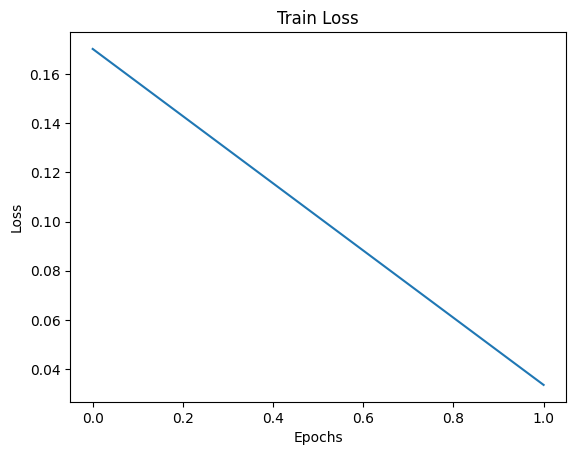

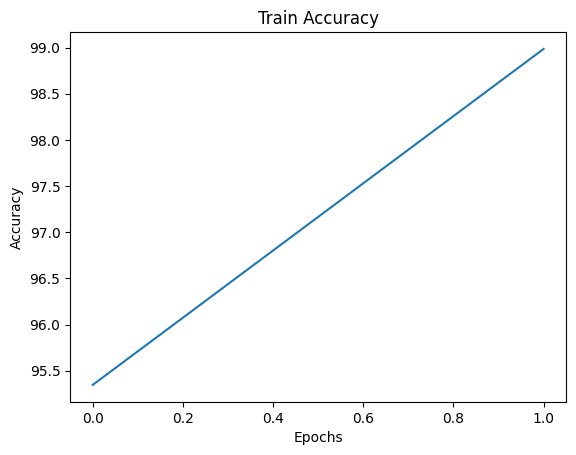

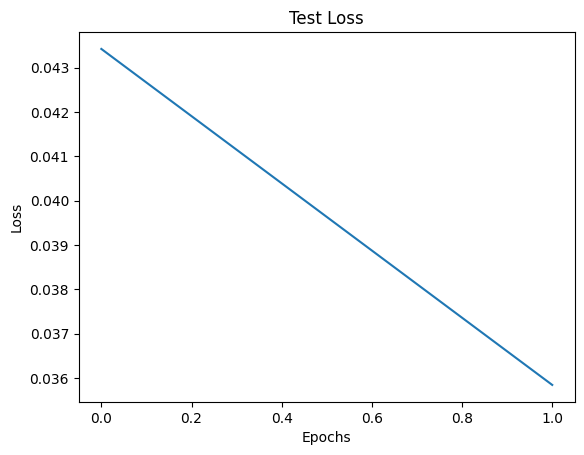

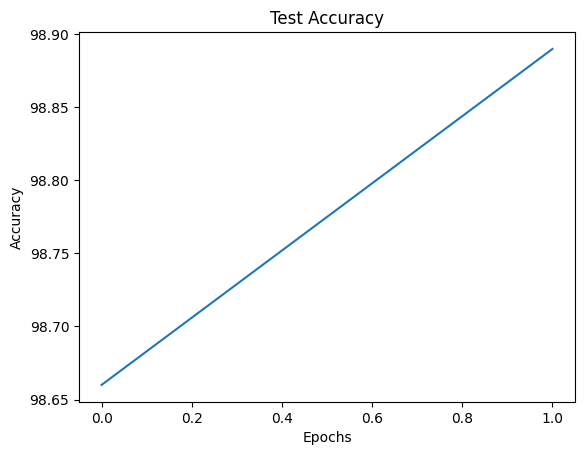

In [ ]:
torch.save(net.state_dict(), 'model.pth')


#TODO: update...

def plot_results(history, title, ylabel):
    plt.figure()
    plt.plot(history)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.show()

plot_results(train_results_loss, "Train Loss", "Loss")
plot_results(train_results_acc, "Train Accuracy", "Accuracy")
plot_results(test_results_loss, "Test Loss", "Loss")
plot_results(test_results_acc, "Test Accuracy", "Accuracy")



# Section 10: Conclusion and final thoughts